In [13]:
#words = open('swedish_names.txt', 'r', encoding='utf-8').read().splitlines()
words = open('names.txt', 'r', encoding='utf-8').read().splitlines()
#words = [w.lower() for w in words if len(w) > 2] # Remove 2< longs words
#words = [w for w in words if w.isascii() and w.isalpha()] # Remove names with åäö or that contains bad things
#words = [w for w in words if '.' not in w]
print(words[-3:])
print(len(words))

['zyrie', 'zyron', 'zzyzx']
32033


In [14]:
letters = sorted(list(set(''.join(words)))) # Get all individual letters sorted, should be alphabet (if all letters are once included in our names)
num_of_unique_letters = len(letters) + 1 # Add 1 for '.' our special char
stoi = {s:i+1 for i,s in enumerate(letters)} # Create a mapping from a char to a int in order to index in tensor
stoi['.'] = 0 # Add . as a special char
itos = {i:s for s,i in stoi.items()} # Create the mapping in reverse
print(num_of_unique_letters)
print(letters)
itos

27
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [15]:
def build_data(words, nChars):
    x, y = [], []
    for w in words:
        chs = list('.'*nChars + w + ".")
        chs = [stoi[c] for c in chs]
        for i in range(len(chs)-nChars):
            x.append(chs[i:i+nChars])
            y.append(chs[i+nChars])
    return (x,y)

# Example 'zuzanna' becomes training example (.. -> z, ..z -> u, and so on until last nna -> .) and chars are converted to the ints

nChars = 3
print(words[-1:])
print(build_data(words[-1:], nChars))


['zzyzx']
([[0, 0, 0], [0, 0, 26], [0, 26, 26], [26, 26, 25], [26, 25, 26], [25, 26, 24]], [26, 26, 25, 26, 24, 0])


In [16]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
%matplotlib inline

cuda:0


'NVIDIA GeForce RTX 3070 Ti'

In [17]:
random.seed(3)
random.shuffle(words)
trainIdx = int(0.8*len(words))
valIdx = int(0.9*len(words))

xTrain, yTrain = build_data(words[0:trainIdx], nChars)
xTrain = torch.tensor(xTrain)
yTrain = torch.tensor(yTrain)

xVal, yVal = build_data(words[trainIdx:valIdx], nChars)
xVal = torch.tensor(xVal)
yVal = torch.tensor(yVal)

xTest, yTest = build_data(words[valIdx:], nChars)
xTest = torch.tensor(xTest)
yTest = torch.tensor(yTest)

In [18]:
g = torch.Generator().manual_seed(2147483647)

nC = 10 # Look up table, can also be seen as the first layer to our network
nHiddenN = 200 # Size of hidden layer

C = torch.randn((num_of_unique_letters, nC), generator=g)
W1 = torch.randn((nC * nChars, nHiddenN), generator=g) * ( (5/3) / (nC*nChars)**0.5 ) # kaiming init
b1 = torch.randn(nHiddenN, generator=g) * 0.01
W2 = torch.randn((nHiddenN, num_of_unique_letters), generator=g) * ( (5/3) / (nHiddenN)**0.5 ) # kaiming init
b2 = torch.randn(num_of_unique_letters, generator=g) * 0.01

parameters = [W1, b1, W2, b2, C]
for p in parameters:
    p.requires_grad = True
    
print(sum(p.nelement() for p in parameters))
trL = []
teL = []

11897


We could also add some search for the best hyper parameters but after testing a few different combinations it seems the architecture of the network is more important to improve on.

      0 / 200000: 3.9421
  10000 / 200000: 2.2386
  20000 / 200000: 2.0611
  30000 / 200000: 2.2904
  40000 / 200000: 1.8461
  50000 / 200000: 2.4005
  60000 / 200000: 2.0998
  70000 / 200000: 1.9118
  80000 / 200000: 1.9720
  90000 / 200000: 1.9083
 100000 / 200000: 2.0786
 110000 / 200000: 2.0513
 120000 / 200000: 1.9194
 130000 / 200000: 2.3442
 140000 / 200000: 2.3836
 150000 / 200000: 2.4357
 160000 / 200000: 2.0062
 170000 / 200000: 2.4934
 180000 / 200000: 2.1927
 190000 / 200000: 2.0127
Last tr loss: 2.2443917138877323


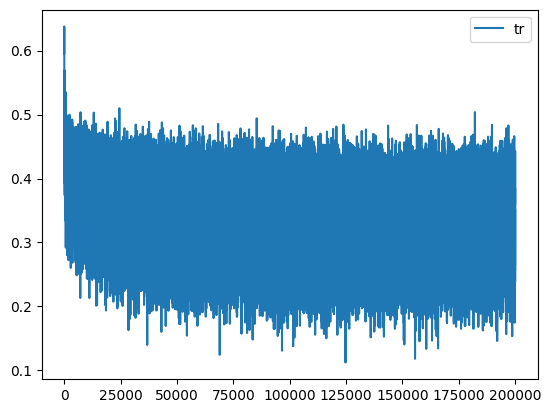

In [19]:
iters = 200_000
lr = 0.1
batch_size = 32

for i in range(iters):
    # Get mini batch idx
    mIdx = torch.randint(0, xTrain.shape[0], (batch_size,))
    
    # Forward
    emb = C[xTrain[mIdx]]

    h = torch.tanh(emb.view(-1, nChars*nC) @ W1 + b1) # We use view to effiently "squash" the look up table's dimentions 
                                                      # in order to have them ass input to our network
    
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, yTrain[mIdx])
    trL.append(loss.log10().item())
    
    # Backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.01 if i < 100_000 else 0.001
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10_000 == 0:
        print(f'{i:7d} /{iters:7d}: {loss.item():.4f}')
        
plt.plot([i for i in range(len(trL))], trL, label='tr')
plt.legend()
print(f'Last tr loss: {10**trL[-1]}')

In [20]:
# Calulate test loss
emb = C[xTest]
h = torch.tanh(emb.view(-1, nChars*nC) @ W1 + b1) # We use view to effiently "squash" the look up table's dimentions 
                                                  # in order to have them ass input to our network
logits = h @ W2 + b2
F.cross_entropy(logits, yTest).item()

2.1417500972747803

Of course these losses cannot be directly compared to the previous work in the "Simple counts and NN.ipynb" but by looking at the names we produce can at least compare them without human interpretations.

In [21]:
for i in range(10):
    out = []
    context = [stoi[c] for c in list('.'*nChars)]
    while True:
        # Forward
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(-1, nChars*nC) @ W1 + b1) # We use view to effiently "squash" the look up table's dimentions 
                                                          # in order to have them ass input to our network
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out))

sir.
gialy.
kit.
abya.
maxilup.
aszilynn.
lick.
janee.
malaser.
leigleycemarr.


As we can see this method produces better names than our first attempt of both Simple counts and NN with only 1 nC and character encoding into more dimensions (instead of just numbers).

In [22]:
if nC == 2:
    # visualize dimensions 0 and 1 of the embedding matrix C for all characters
    plt.figure(figsize=(8,8))
    plt.scatter(C[:,0].data, C[:,1].data, s=200)
    print(itos)
    for i in range(C.shape[0]):
        plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
    plt.grid('minor')
else:
    print("Cant visualize with more than 2 dims")

Cant visualize with more than 2 dims
